In [1]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import math 
import scipy
%matplotlib inline


Процесс $X_t =  \frac{\xi_0 t}{\sqrt{\pi}} + \sqrt{\frac{2}{\pi}} \sum_{k = 1}^{\inf} \frac{\sin{k t}}{k} \xi_k$, где $\{\xi_n, n\in Z_+\}$ - независимые $N(0,1)$ с.в., является винеровским на отрезке $[0, \pi]$

In [97]:
class WinerProccess:
    def __init__(self, precision = 10000):
        # инициализация процесса
        
        self.accuracy = precision
        self.xi_array = sps.norm.rvs(size=(1,self.accuracy +1))
        self.start_points = scipy.array([self.xi_array[0,0] * scipy.pi])
        self.counted = 1
        
        
    def _init_xi(self, periods):
        # инициализация случайных величин на заданном количестве периодов
        
        if(periods < 1) : return
        
        xi_periods = sps.norm.rvs(size=(periods,self.accuracy +1))
        self.xi_array = scipy.append(self.xi_array, xi_periods)
        
        # на левых и правых концах отрезков аргумент синусов кратен pi -> 
        # всё, что под знаком суммы, всегда ноль
        # cumsum(a, axis=0) накопительная сумма по оси 0
        xi_zeros_new = xi_periods[:,0]
        add_start = scipy.cumsum(xi_zeros_new, axis=0) 
        add_start /= scipy.sqrt(scipy.pi)
        add_start *= scipy.pi
        add_start += self.start_points[-1]
        self.start_points = scipy.append(self.start_points, add_start)
        self.counted += periods
        
        
    def __getitem__(self, times):
        # в periods считаем номера периодов,
        # в которые попадают соответствующие time
        # находим наибольший из периодов,
        # инициализируем до этого периода включительно,
        # по periods составляем мартицу xi, 
        # подгружаем массив начальных значений,
        # матрицу синусов, матрицу значений 1..k 
        # массив xi_0
        # формула собитается как поэлементные операции
        # cо всем, что перечисленно выше
        
        size = len(times)
        mod = scipy.ones(size, float) * scipy.pi
        periods = (times // mod)
        periods = periods.astype(int)
        time_in_period = times % mod
        
        not_counted = int(np.max(periods)) - self.counted + 1 
        self._init_xi(not_counted)
        
        k_row = scipy.arange(1, self.accuracy, 1)
        arg_sin = np.expand_dims(time_in_period, axis=1) * k_row
        xi_s = self.xi_array[periods].reshape(periods.shape[0], 1)
        coefficients = scipy.sin(arg_sin) / k_row
        coefficients = coefficients * xi_s
        
        #axis=1 - построчно
        row_sums = scipy.sum(coefficients, axis=1)
        row_sums *= scipy.sqrt(scipy.pi / 2)
        result = self.start_points[periods] 
        result += self.xi_array[periods][0]* time_in_period 
        / scipy.sqrt(scipy.pi)
        result += row_sums
        return result


        
        

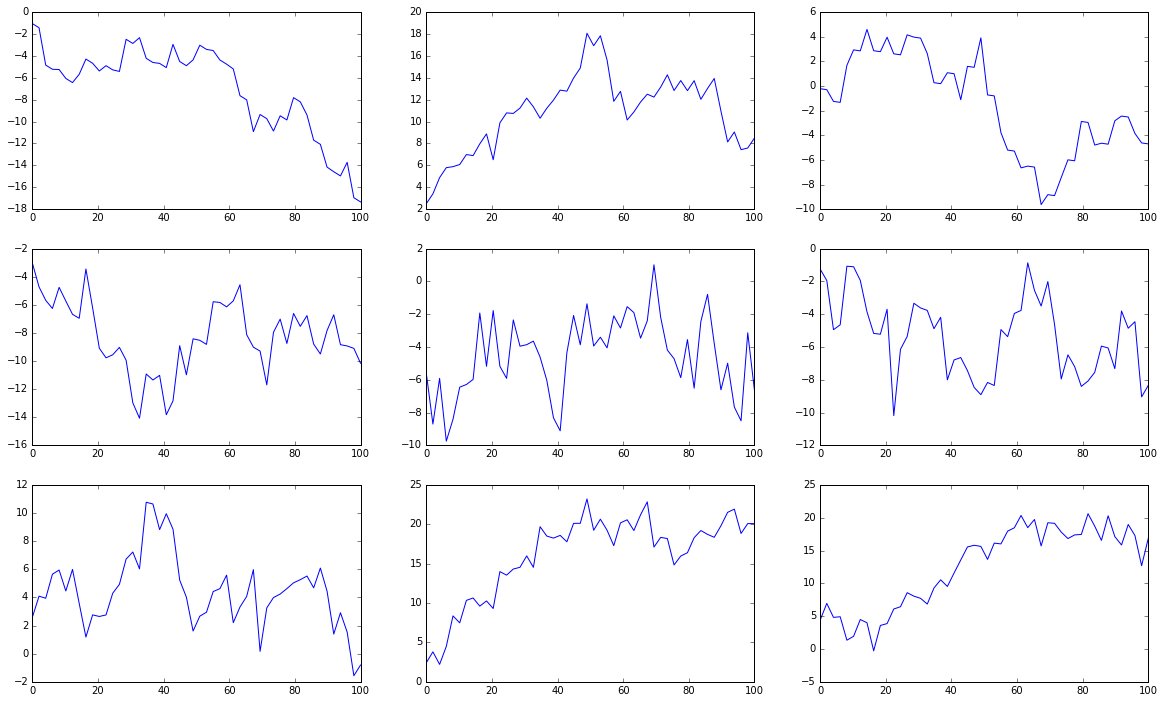

In [98]:
gaps = [[0,10],[0, 1],[0,0.1]]
plt.figure(figsize=(20, 12))
for i in range(3):
    for j in range(3):
        plt.subplot(3,3,i*3+j+1)
        times = np.linspace(0, 100)
        Wt = WinerProccess(10**i)
        plt.plot(times, Wt[times])

In [79]:
def _winer_proccess_path(end_time, step, precision=10000):
    # Я беру такие моменты времени, чтобы ряд синусов kt
    # t \in [0,\pi] совпадал для всех отрезков
    
    max_period = end_time // scipy.pi
        
    max_period = int(max_period)
        
    times =  np.arange(0, scipy.pi, step)
    times = times.reshape(len(times),1)
    all_times = np.array([])
    size = len(times)
    k_row = scipy.arange(1, precision, 1)
    arg_sin = np.expand_dims(times, axis=1) * k_row
    coefficients = scipy.sin(arg_sin) / k_row
    result = np.array([])
    zeros = np.array([])
        
    for i in range(max_period):
        xi_s = sps.norm.rvs(size=(precision + 1))
        x_0 = xi_s[0]
        xi_s = xi_s[1:]
        
        new_zero = x_0 * scipy.sqrt(scipy.pi)
        if i == 0: 
            zeros = np.append(zeros, [new_zero])
        else:
            new_zero += zeros[-1]
            zeros = np.append(zeros, [new_zero])
        
        coefficients = coefficients * xi_s
        start = new_zero
        values = np.ones(len(times)) * xi_0 
        values /= scipy.sqrt(scipy.pi / 2)
        values += start
        row_sums = scipy.sum(coefficients, axis=1)
        row_sums *= scipy.sqrt(scipy.pi / 2)
            
        values += row_sums
        result = np.append(result, values)
            
        times_here = np.ones(size) * scipy.pi * i
        times_here += times
        all_times = np.append(all_times,times_here)
        
    times = np.arange(scipy.pi * max_period, end_time, step)
    k_row = scipy.arange(1, precision, 1)
    arg_sin = np.expand_dims(times, axis=1) * k_row
    
    xi_s = sps.norm.rvs(size=(precision + 1))
    x_0 = xi_s[0]
    xi_s = xi_s[1:]
    
    new_zero = x_0 * scipy.sqrt(scipy.pi)
    if i != 0: new_zero += zeros[-1]
    zeros = np.append(zeros, [new_zero])
    
    coefficients = scipy.sin(arg_sin) / k_row
    coefficients = coefficients * xi_s
    start = new_zero
    values = np.ones(len(times)) * xi_0 
    values /= scipy.sqrt(scipy.pi / 2)
    values += start
    row_sums = scipy.sum(coefficients, axis=1)
    row_sums *= scipy.sqrt(scipy.pi / 2)
            
    values += row_sums
    result = np.append(result, values)
    
    result = np.append(result, values)
    all_times = np.append(all_times,times)
        
    return all_times, result        
        

In [129]:
def winer_proccess_path(end_time, step, prec=10000):
    times = np.arange(0, end_time, step)
    WinerValue = []
    WP = WinerProccess(precision=prec)
    for i in range(len(times) // 500):
        if i == 0:
            WinerValue = WP[times[:500]]
        else:
            WinerValue = np.append(WinerValue, 
                                   np.array(WP[times[i * 500 :(i + 1) * 500]] 
                                            + WinerValue[-1]))
    if( len(times) % 500 != 0) :
        WinerValue = np.append(WinerValue, 
                               np.array(WP[times[500 * (len(times)//500)]]))
    return times, WinerValue

In [132]:
%time times, values = winer_proccess_path(5000, 0.1)

CPU times: user 21.6 s, sys: 1.57 s, total: 23.2 s
Wall time: 23.2 s
